In [1]:
!pip install pmdarima

  Using cached statsmodels-0.14.1-cp38-cp38-win_amd64.whl.metadata (9.8 kB)
   ---------------------------------------- 615.5/615.5 kB 2.1 MB/s eta 0:00:00
Using cached statsmodels-0.14.1-cp38-cp38-win_amd64.whl (10.0 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

import pmdarima as pm  # for auto_arima

%matplotlib inline
sns.set_style("whitegrid")

In [6]:

data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
data.rename(columns={'Passengers': 'y'}, inplace=True)

data.head(15)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [7]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


#Passengers    0
dtype: int64

In [14]:
data.rename(columns={'#Passengers': 'y'}, inplace=True)

In [15]:
ts = data['y']
ts = ts.asfreq('MS')  # Monthly start frequency if not already
ts.head()


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Freq: MS, Name: y, dtype: int64

# EDA

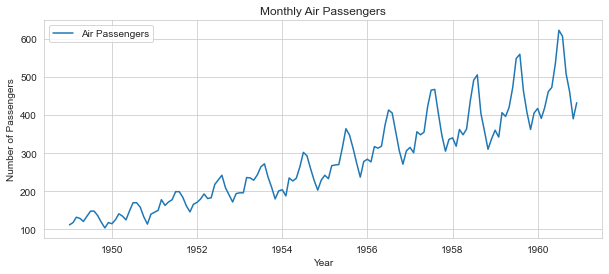

In [16]:
plt.figure(figsize=(10,4))
plt.plot(ts, label='Air Passengers')
plt.title('Monthly Air Passengers')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

# Decompose  time series

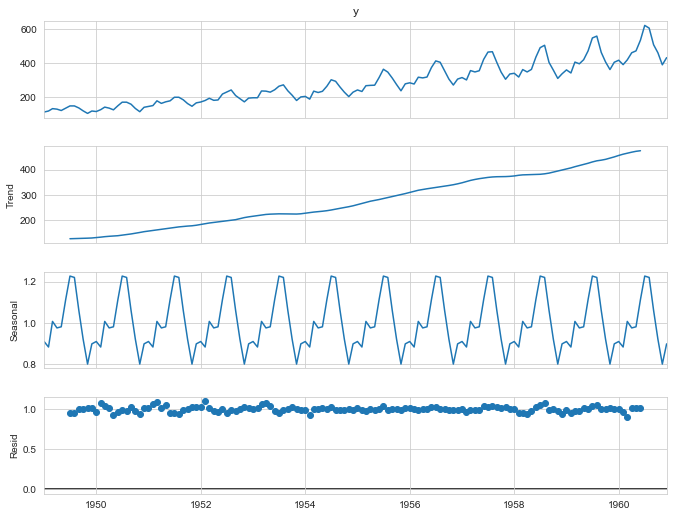

In [17]:
decomp = seasonal_decompose(ts, model='multiplicative')
fig = decomp.plot()
fig.set_size_inches(10,8)
plt.show()

### Seasonal decompsing with multiplicative method shows that there additive seasonal pattern in dataset and data is linear in upword direction as we cna see from trend. futher the series is very close to zero where the decompositon method which is multpilicaitve has no any white noise

# Check Stationarity

## checking the series whether its stationary or not
## If p value p>0.005 then not-stationary

In [18]:
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("=> Stationary")
    else:
        print("=> Non-Stationary")

adf_test(ts)

ADF Statistic : 0.8153688792060457
p-value : 0.991880243437641
#Lags Used : 13
Number of Observations Used : 130
=> Non-Stationary


### If p-value > 0.05, the series is non-stationary, so  differencing required

Augmented Dickey-Fuller Test: Original Series
ADF Statistic: 0.8153688792060457
p-value: 0.991880243437641
#Lags Used: 13
Number of Observations Used: 130
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
=> The series is likely non-stationary. (Fail to reject H0)




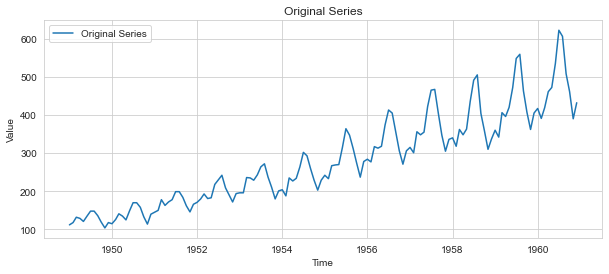

Augmented Dickey-Fuller Test: First-Differenced Series
ADF Statistic: -2.8292668241699963
p-value: 0.05421329028382592
#Lags Used: 12
Number of Observations Used: 130
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
=> The series is likely non-stationary. (Fail to reject H0)




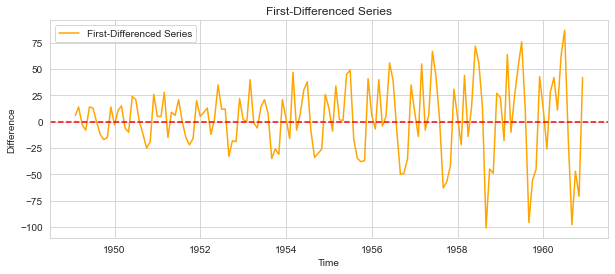

Augmented Dickey-Fuller Test: After 2nd Difference
ADF Statistic: -16.384231542468502
p-value: 2.7328918500142026e-29
#Lags Used: 11
Number of Observations Used: 130
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
=> The series is likely stationary. (Reject H0)




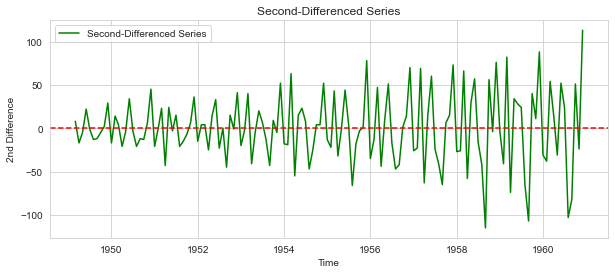

In [59]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result[0:4],labels):
        print(f"{label}: {value}")

    print("Critical Values:")
    for key,value in result[4].items():
        print(f'   {key}: {value}')
    
    # Interpret the test result
    if result[1] <= 0.05:
        print("=> The series is likely stationary. (Reject H0)")
    else:
        print("=> The series is likely non-stationary. (Fail to reject H0)")
    print('\n')

# ADF test on original series
adf_test(ts, title='Original Series')

# Plot original series
plt.figure(figsize=(10,4))
plt.plot(ts, label='Original Series')
plt.title('Original Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# First differencing
ts_diff1 = ts.diff().dropna()
adf_test(ts_diff1, title='First-Differenced Series')

# Plot first-differenced series
plt.figure(figsize=(10,4))
plt.plot(ts_diff1, label='First-Differenced Series', color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.title('First-Differenced Series')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.legend()
plt.show()

# Second differencing
ts_diff2 = ts_diff1.diff().dropna()
adf_test(ts_diff2, title='After 2nd Difference')

# Plot second-differenced series
plt.figure(figsize=(10,4))
plt.plot(ts_diff2, label='Second-Differenced Series', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title('Second-Differenced Series')
plt.xlabel('Time')
plt.ylabel('2nd Difference')
plt.legend()
plt.show()

### There are 2 differencing required in order to make data stationary

## Identifying AR/MA terms using ACF & PACF

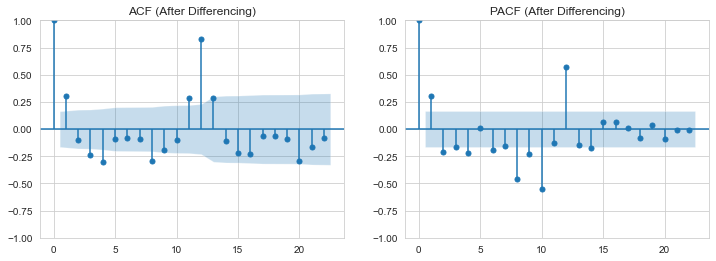

In [60]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
plot_acf(ts_diff, ax=axes[0], title='ACF (After Differencing)')
plot_pacf(ts_diff, ax=axes[1], title='PACF (After Differencing)')
plt.show()

#### From above graphs we can conclude that acf has 4 values and PACF has 3 values

# Train Test SPlitting

In [61]:
train = ts[:-12]
test = ts[-12:]
len(train), len(test)

(132, 12)

## 1: Exponential Smoothing model Fitting for 12 Period Forecasting

In [28]:
model_ets = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12).fit()
ets_pred = model_ets.forecast(12)

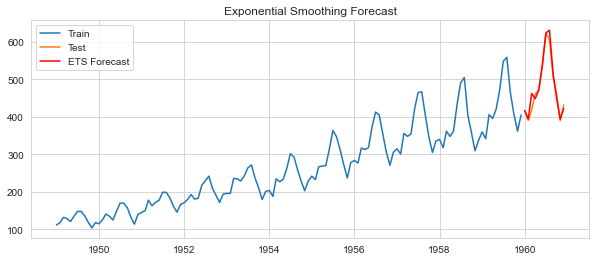

Test RMSE: 15.810


In [65]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(ets_pred.index, ets_pred, label='ETS Forecast', color='red')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

mse = mean_squared_error(test, ets_pred)
rmse = np.sqrt(mse)
print('Test RMSE: %.3f' % rmse)

## 2: AutoRegressive) Model (AR)

In [32]:
model_ar = AutoReg(train, lags=1).fit()
ar_pred = model_ar.predict(start=test.index[0], end=test.index[-1])

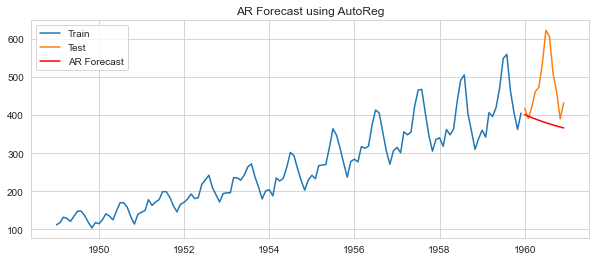

In [33]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(ar_pred.index, ar_pred, label='AR Forecast', color='red')
plt.title('AR Forecast using AutoReg')
plt.legend()
plt.show()

## 3: Moving Average Model (MA)

In [35]:
# Moving Average is implemented using ARIMA with AR=0
model_ma = ARIMA(train, order=(0,1,1)).fit()
ma_pred = model_ma.forecast(steps=12)

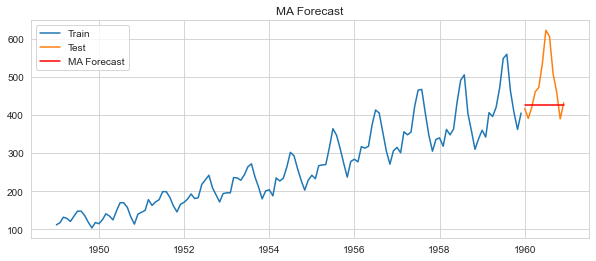

In [36]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(ma_pred.index, ma_pred, label='MA Forecast', color='red')
plt.title('MA Forecast')
plt.legend()
plt.show()


## 4: ARIMA Model

In [37]:
model_arima = pm.auto_arima(train, seasonal=False, trace=True, 
                            error_action='ignore', suppress_warnings=True,
                            start_p=1, start_q=1, d=1, max_p=5, max_q=5)
model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1258.440, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1277.589, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1268.313, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1264.738, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1276.259, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1262.608, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1263.896, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1218.683, Time=0.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -603.341
Date:                Fri, 20 Dec 2024   AIC                           1218.683
Time:                        17:00:59   BIC                           1235.934
Sample:                    01-01-1949   HQIC                          1225.692
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7157      0.212      3.379      0.001       0.301       1.131
ar.L1          1.6431      0.028     57.904      0.000       1.587       1.699
ar.L2         -0.9129      0.027    -33.338      0.000      -0.967      -0.859
ma.L1         -1.8478      0.036    -51.463      0.000      -1.918      -1.777
ma.L2          0.9466      0.038     24.988      0.000       0.872       1.021
sigma2       564.8457     67.205      8.405      0.000     433.126     696.565
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.36   Prob(JB):                         0.39
Heteroskedasticity (H):               6.40   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
model_arima_final = ARIMA(train, order=model_arima.order).fit()
arima_pred = model_arima_final.forecast(steps=12)

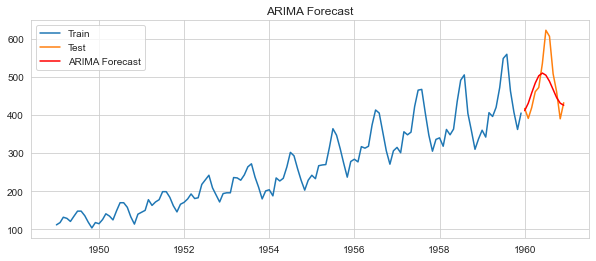

In [39]:
plt.figure(figsize=(10,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(arima_pred.index, arima_pred, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# 5:  SARIMA Model

In [40]:
# Use auto_arima with seasonality
model_sarima = pm.auto_arima(train, seasonal=True, m=12, trace=True,
                             error_action='ignore', suppress_warnings=True)
model_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.46 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.49 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.40 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.59 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.36 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.58 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.16 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.42 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Fri, 20 Dec 2024   AIC                            905.686
Time:                                    17:03:11   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
order = model_sarima.order
seasonal_order = model_sarima.seasonal_order
model_sarima_final = ARIMA(train, order=order, seasonal_order=seasonal_order).fit()
sarima_pred = model_sarima_final.forecast(steps=12)

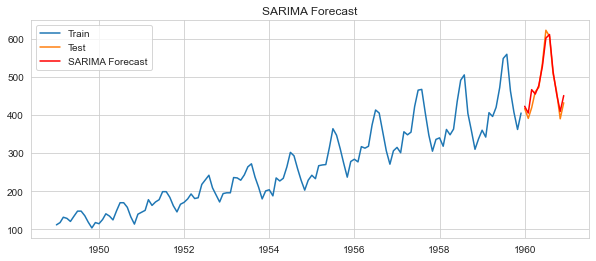

In [43]:
plt.figure(figsize=(10,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

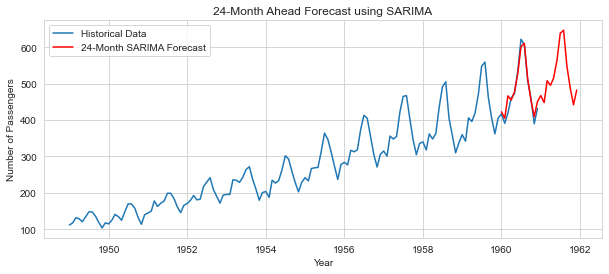

In [47]:
# Let's pick SARIMA (model_sarima_final) from previous code snippet
# Forecast 24 months beyond the test period
extended_steps = 24
long_forecast = model_sarima_final.forecast(steps=extended_steps)

plt.figure(figsize=(10,4))
plt.plot(ts, label='Historical Data')
plt.plot(long_forecast.index, long_forecast, label='24-Month SARIMA Forecast', color='red')
plt.title('24-Month Ahead Forecast using SARIMA')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

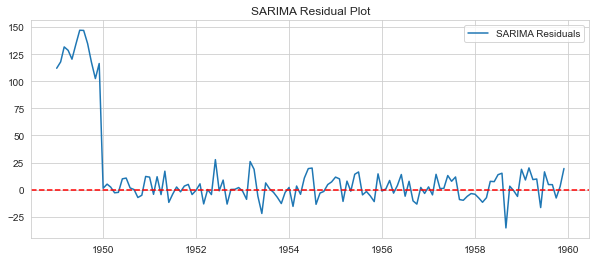

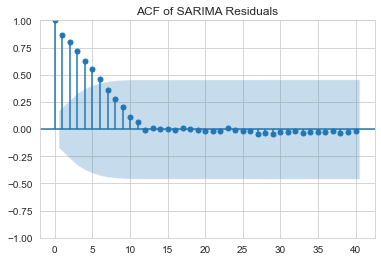

In [48]:
# Residuals for SARIMA on the training portion
sarima_resid = model_sarima_final.resid

plt.figure(figsize=(10,4))
plt.plot(sarima_resid, label='SARIMA Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('SARIMA Residual Plot')
plt.legend()
plt.show()

# Check if residuals are white noise using ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(sarima_resid.dropna(), lags=40)
plt.title('ACF of SARIMA Residuals')
plt.show()

## 6: Persistance model

In [45]:
last_train_value = train.iloc[-1]

persistence_pred = pd.Series([last_train_value]*len(test), index=test.index)

# Evaluate Persistence Model
from sklearn.metrics import mean_absolute_error, mean_squared_error
def evaluate_forecast(true, pred):
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mape = (abs(true - pred)/true).mean() * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

persistence_metrics = evaluate_forecast(test, persistence_pred)
print("Persistence Model:", persistence_metrics)

Persistence Model: {'MAE': 76.0, 'RMSE': 102.97653454387881, 'MAPE': 14.251338486772209}


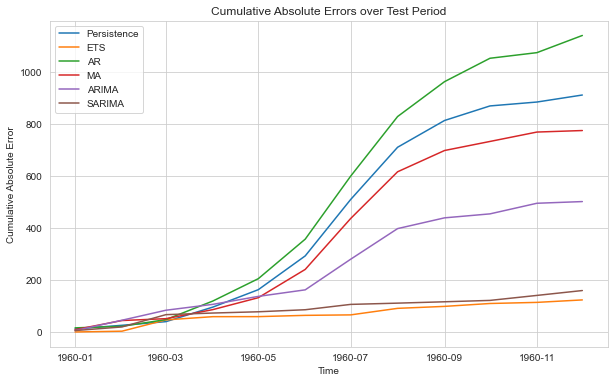

In [49]:
plt.figure(figsize=(10,6))
for m,p in zip(models, predictions):
    errors = abs(test - p)
    cum_error = errors.cumsum()
    plt.plot(cum_error, label=m)

plt.title('Cumulative Absolute Errors over Test Period')
plt.xlabel('Time')
plt.ylabel('Cumulative Absolute Error')
plt.legend()
plt.show()


# Evaluate and Compare Models

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_forecast(true, pred):
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true - pred)/true))*100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

models = ['Persistence', 'ETS', 'AR', 'MA', 'ARIMA', 'SARIMA']
predictions = [persistence_pred, ets_pred, ar_pred, ma_pred, arima_pred, sarima_pred]

for m,p in zip(models, predictions):
    print(m, evaluate_forecast(test, p))


Persistence {'MAE': 76.0, 'RMSE': 102.97653454387881, 'MAPE': 14.251338486772209}
ETS {'MAE': 10.302260794882585, 'RMSE': 15.809562602748581, 'MAPE': 2.207266656333601}
AR {'MAE': 95.0939270016869, 'RMSE': 122.10296979355947, 'MAPE': 18.10860941558655}
MA {'MAE': 64.61059557008586, 'RMSE': 89.66224156414275, 'MAPE': 12.163303573320004}
ARIMA {'MAE': 41.834798088152354, 'RMSE': 55.22283887988983, 'MAPE': 8.220491113303806}
SARIMA {'MAE': 13.309315431256692, 'RMSE': 17.81560143527435, 'MAPE': 2.9673106140777556}


### **Model Comparison Summary**

-> Persistence modelshowed high error values showing poor predictive power.

-> Exponential Smoothing (ETS)** performed exceptionally well, with the lowest error rates across all metrics, followed closely by SARIMA.

-> Auto-Regressive (AR) model had the highest error values while the Moving Average (MA) model performed moderately but was still less effective than ETS and SARIMA.

-> ARIMA improved upon AR and MA but fell short of ETS and SARIMA accuracy.

-> ETS and SARIMA were the most accurate models with ETS slightly outperforming SARIMA.